# Linear regression coefficients

[Machine Learning Interpretability course](https://www.trainindata.com/p/machine-learning-interpretability)

In this notebook we will evaluate the coefficients of the linear regression models provided by statsmodels.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

# the dataset for the demo
from sklearn.datasets import fetch_california_housing
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

### Load data

In [2]:
# load the California House price data from Scikit-learn
X, y = fetch_california_housing(return_X_y=True, as_frame=True)
X = X.drop(columns = ["Latitude", "Longitude"])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0,
)

# Scale data
scaler = MinMaxScaler().set_output(transform="pandas").fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Train linear regression

In [3]:
# Our model needs an intercept so we add a column of 1s:

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [4]:
# Fit model

linreg = sm.OLS(y_train, X_train)
results = linreg.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            MedHouseVal   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     2942.
Date:                Tue, 14 Nov 2023   Prob (F-statistic):               0.00
Time:                        10:47:31   Log-Likelihood:                -16796.
No. Observations:               14448   AIC:                         3.361e+04
Df Residuals:                   14441   BIC:                         3.366e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0659      0.028      2.340      0.0

## Coefficients direction (sign)

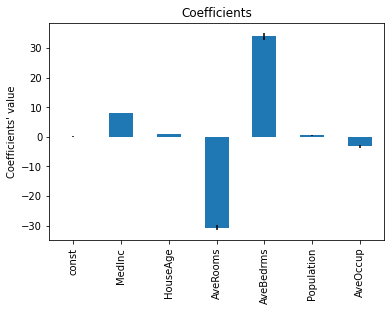

In [5]:
# Coefficients value

s = pd.Series(
    results.params,
    index=X_train.columns,
)

s.plot.bar(yerr=results.bse)
plt.ylabel("Coefficients' value")
plt.title("Coefficients")
plt.show()

We see that the variability of the coefficients is different.

We also see that the variables `AveRooms` and `AveBdrms` have opposite direction. We'd expect, intuitively that they have the same direction. And we also expect these variables to be highly correlated. More on this later.

Note that the errors estimated by statsmodels are smaller than those observed with cross-validation in the previous notebook.

## Coefficient absolute value - feature importance

This is what we normally use as a measure of feature importance.

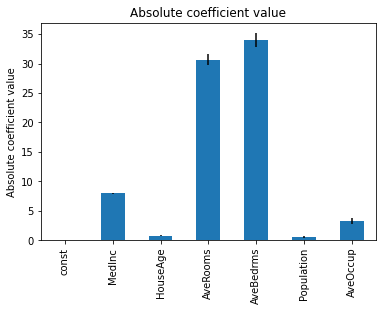

In [6]:
# Plot mean coefficient and std

s = pd.Series(
    np.abs(results.params),
    index=X_train.columns,
)

s.plot.bar(yerr=results.bse)
plt.ylabel("Absolute coefficient value")
plt.title("Absolute coefficient value")
plt.show()

From the previous plot, we'd expect the variables `AveRooms` and `AveBdrms` to be the ones with the highest importance. However, the coefficients for those variables also shows more variability, or a bigger error. Then, we can trust them less.

## t

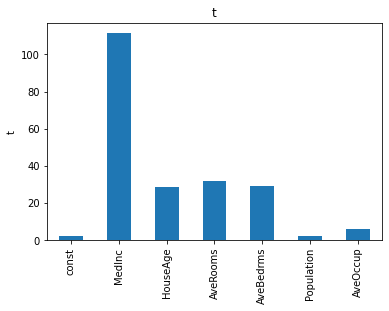

In [7]:
# estimate and plot t

s = pd.Series(
    np.abs(results.tvalues),
    index=X_train.columns,
)

s.plot.bar()
plt.ylabel("t")
plt.title("t")
plt.show()

After correcting the coefficient by its error, we see that `MedInc` is a more robust predictor of house price.

## Confidence intervals

Statsmodels documentation is quite poor in my opinion, so here I leave a link to an explanation of the values we obtain when fitting `OLS`: https://stackoverflow.com/questions/60963178/what-does-obs-confidence-interval-in-statsmodels-linear-regression-in-python

We will plot the predictions and its conficence intervals vs the truth, to get a better view of the model performance.

In [8]:
# Obtain first 50 predictions for train set

df = results.get_prediction(X_test.head(50)).summary_frame()

df.head()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
14740,2.040811,0.007459,2.026189,2.055432,0.523596,3.558025
10101,2.846458,0.010319,2.826233,2.866684,1.329180,4.363737
20566,2.155244,0.007979,2.139605,2.170883,0.638019,3.672468
2670,1.731485,0.011593,1.708762,1.754209,0.214171,3.248799
15709,2.835506,0.014450,2.807183,2.863830,1.318098,4.352915


In [9]:
# add target variable to results

df["true"] = y_test.head(50)

df.head()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,true
14740,2.040811,0.007459,2.026189,2.055432,0.523596,3.558025,1.369
10101,2.846458,0.010319,2.826233,2.866684,1.329180,4.363737,2.413
20566,2.155244,0.007979,2.139605,2.170883,0.638019,3.672468,2.007
2670,1.731485,0.011593,1.708762,1.754209,0.214171,3.248799,0.725
15709,2.835506,0.014450,2.807183,2.863830,1.318098,4.352915,4.600


In [10]:
# sort results by value of the prediction

df = df.sort_values(by=["mean"])

df.head()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,true
2400,0.934639,0.013197,0.908772,0.960506,-0.582726,2.452003,1.000
13895,0.982493,0.012755,0.957491,1.007495,-0.534857,2.499843,0.542
13579,1.020219,0.018329,0.984291,1.056146,-0.497351,2.537788,0.795
74,1.074692,0.013977,1.047296,1.102088,-0.442700,2.592083,1.375
9228,1.100908,0.012909,1.075605,1.126210,-0.416447,2.618263,0.922


Text(0.5, 0, 'predictions')

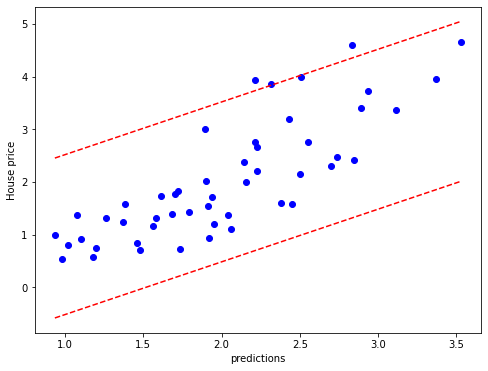

In [11]:
# PLot predictions vs target plus confidence intervals

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(df["mean"], df["true"], "bo")
ax.plot(df["mean"], df["obs_ci_upper"], "r--")
ax.plot(df["mean"], df["obs_ci_lower"], "r--")
ax.set_ylabel("House price")
ax.set_xlabel("predictions")

Text(0.5, 0, 'predictions')

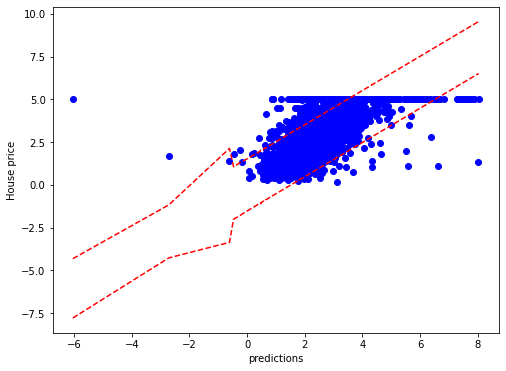

In [12]:
# Plot all results

df = results.get_prediction(X_test).summary_frame()
df["true"] = y_test
df = df.sort_values(by=["mean"])

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(df["mean"], df["true"], "bo")
ax.plot(df["mean"], df["obs_ci_upper"], "r--")
ax.plot(df["mean"], df["obs_ci_lower"], "r--")
ax.set_ylabel("House price")
ax.set_xlabel("predictions")

In [13]:
y.min(), y.max()

(0.14999, 5.00001)